# Image detection

In [6]:
import ultralytics

In [7]:
ultralytics.checks()

Ultralytics YOLOv8.0.51 🚀 Python-3.10.6 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080, 8111MiB)
Setup complete ✅ (8 CPUs, 31.3 GB RAM, 36.2/217.5 GB disk)


## Inference

In [8]:
model = ultralytics.YOLO('models/yolov8s-agar-s480-b10-e50.pt')

In [9]:
results = model.predict('data/creighton')


image 1/7 /mnt/d/projects/colony/data/creighton/IM10CN-R2A_edit.jpeg: 480x480 3 unknowns, 14 b_subtiliss, 30 s_aureuss, 5 e_colis, 7.1ms
image 2/7 /mnt/d/projects/colony/data/creighton/IM10CN-TSA_edit.jpeg: 480x480 3 unknowns, 6 b_subtiliss, 24 s_aureuss, 52 e_colis, 7.1ms
image 3/7 /mnt/d/projects/colony/data/creighton/IM50-TSA_edit.jpeg: 480x480 1 unknown, 2 b_subtiliss, 70 s_aureuss, 79 e_colis, 29 p_aeruginosas, 7.1ms
image 4/7 /mnt/d/projects/colony/data/creighton/TH10N-R2A_edit.jpeg: 480x480 1 unknown, 10 b_subtiliss, 25 s_aureuss, 19 e_colis, 7.3ms
image 5/7 /mnt/d/projects/colony/data/creighton/TH10N-TSA_edit.jpeg: 480x480 13 s_aureuss, 287 e_colis, 7.6ms
image 6/7 /mnt/d/projects/colony/data/creighton/TH50CN-R2A_edit.jpeg: 480x480 9 b_subtiliss, 30 s_aureuss, 18 e_colis, 7.3ms
image 7/7 /mnt/d/projects/colony/data/creighton/TH50CN-TSA_edit.jpeg: 480x480 2 unknowns, 17 s_aureuss, 47 e_colis, 7.4ms
Speed: 0.3ms preprocess, 7.3ms inference, 0.9ms postprocess per image at shape (

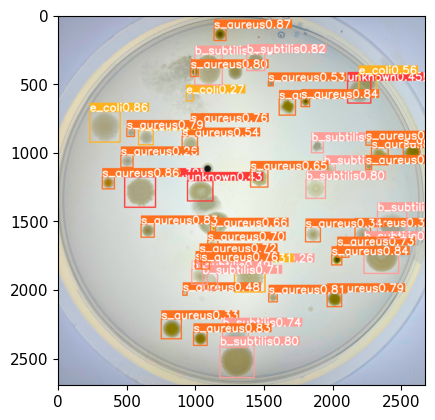

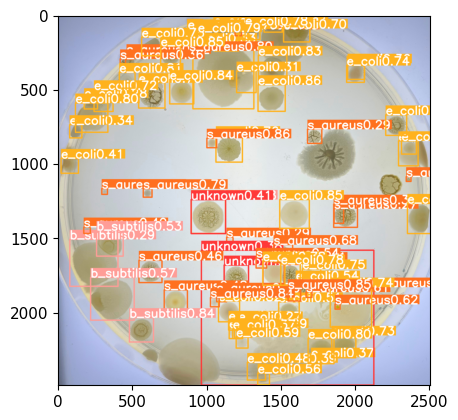

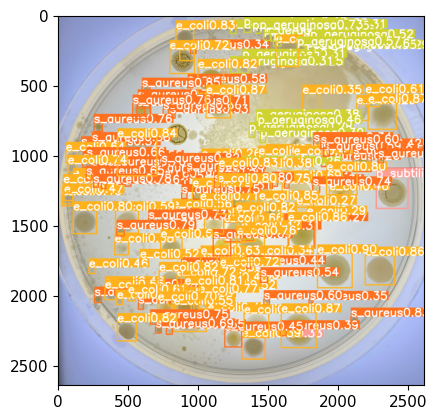

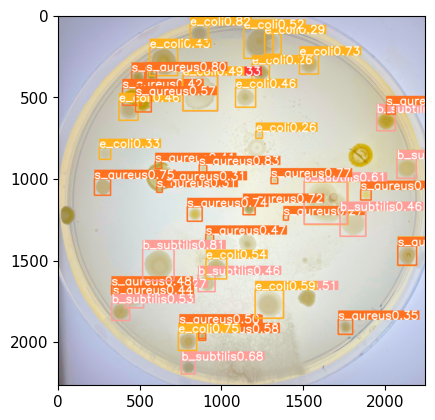

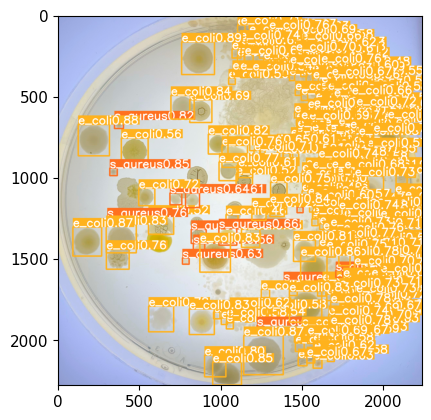

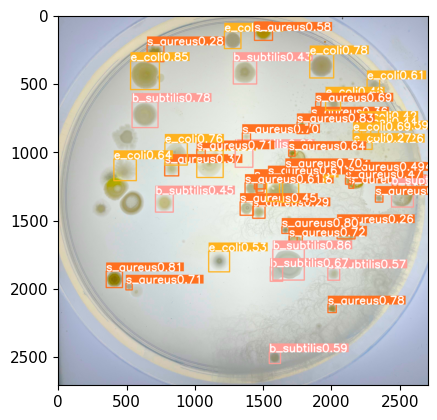

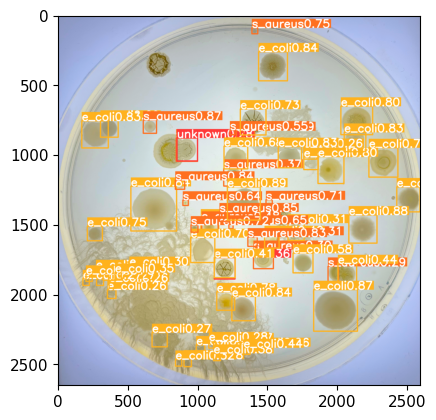

In [10]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

for result in results:
    img = cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [ ]:
result.numpy

## Data processing

In [ ]:
%matplotlib inline

import json
import os
import pathlib

import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches

# Setup the location for the AGAR dataset.
DATA_PATH = 'data/agar/dataset/'


In [ ]:
# Determine unique labels from dataset.
label_set = set([])

for c, file_path in enumerate(pathlib.Path(DATA_PATH).glob('*.json')):
    if c % 1000 == 0:
        print(f'Files opened: {c}')
    with open(file_path, 'r') as f:
        json_dict = json.loads(f.read())
        label_set.update(json_dict['classes'])

with open(os.path.join(DATA_PATH, '../labels.txt')) as f:
    for c, label in enumerate(label_set):
        f.write(f'{c+1}:{label}\n')

In [ ]:
# Read the class labels back from disk.

class_labels = {}
with open(os.path.join(DATA_PATH, '../labels.txt')) as f:
    class_string = f.read()
    for class_tuple in class_string.split('\n'):
        if class_tuple:
            class_id, class_name = class_tuple.split(':')
            class_labels[class_name] =  int(class_id)

In [ ]:
# Convert the JSON labels into TXT equivalent files.

# Expected format for the label files is image000.txt with rows of:
# class_number box1_x1_ratio box1_y1_ratio box1_width_ratio box1_height_ratio
# The json records (x,y) as the ll_corner and txt encodes it as center.
def convert_json_to_txt_label(label_dict, image_width, image_height, class_dict, default_class_id=0):
    class_id = class_dict.get(label_dict['class']) or default_class_id
    return [class_id, 
            (label_dict['x'] + 0.5 * label_dict['width']) / image_width,
            (label_dict['y'] + 0.5 * label_dict['height']) / image_height,
            label_dict['width'] / image_width,
            label_dict['height'] / image_height,
            ]

for c in range(1,18000+1):
    if c % 1000 == 0:
        print(f'Processed {c}')
    try:
        im = Image.open(os.path.join(DATA_PATH, f'{c}.jpg'))
        with open(os.path.join(DATA_PATH, f'{c}.json'), 'r') as f:
            json_dict = json.loads(f.read())
        with open(os.path.join(DATA_PATH, f'{c}.txt'), 'w') as f:
            if 'labels' in json_dict:
                for class_bbox in json_dict['labels']:
                    id, x, y, w, h = convert_json_to_txt_label(class_bbox, im.width, im.height, class_labels)
                    f.write(f'{id:d} {x} {y} {w} {h}\n')
    except Exception as err:
        print(f'Image {c} failed.\nERROR= {err=}\nTYPE= {type(err)=}')

In [ ]:
index = 4001
im = Image.open(os.path.join(DATA_PATH, f'{index}.jpg'))
with open(os.path.join(DATA_PATH, f'{index}.json'), 'r') as f:
    json_dict = json.loads(f.read())
with open(os.path.join(DATA_PATH, f'{index}.txt'), 'r') as f:
    bbox_raw = [[float(x) for x in line.split(' ') if x] for line in f.read().split('\n') if line]



In [ ]:
# Create figure and axes for the original JSON data.
fig, ax = plt.subplots()
ax.imshow(im)
ax.grid(visible=False)
for bbox in json_dict['labels']:
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox['x'], bbox['y']), bbox['width'], bbox['height'], linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

# Create figure and axes for the new TXT data.
fig, ax = plt.subplots()
ax.imshow(im)
ax.grid(visible=False)
for bbox in bbox_raw:
    x = im.width * bbox[1]
    y = im.height * bbox[2]
    w = im.width * bbox[3]
    h = im.height * bbox[4]
    rect = patches.Rectangle((x-0.5*w, y-0.5*h), w, h, linewidth=1, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

## Training

In [3]:
model = ultralytics.YOLO('models/yolov8s-blood-cell-detection.pt')

In [ ]:
# yolo train model="models/yolov8s-blood-cell-detection.pt" data="data/agar/agar.yaml" epochs=50 imgsz=480 batch=8
model.train(data='data/agar/agar.yaml', imgsz=480, batch=8, epochs=3)

# Image classification